In [1]:

import numpy as np#OLD CODE
def find_connected_pairs(adjacency_matrix):
    connected_pairs = []
    num_nodes = len(adjacency_matrix)

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Ensure we only consider distinct pairs
            if adjacency_matrix[i][j] == 1:  # If there's a connection between nodes i and j
                connected_pairs.append([i, j])  # Use a list [i, j] instead of a tuple (i, j)

    return connected_pairs

def find_two_node_subgroups(adjacency_matrix, num_pairs):
    connected_pairs = find_connected_pairs(adjacency_matrix)
    num_nodes = len(adjacency_matrix)
    
    all_subgroups = []
    
    def is_valid(curr_pair):
        nodes = [node for pair in curr_pair for node in pair]
        return len(set(nodes)) == num_nodes
    
    def backtrack(curr_pair, remaining_pairs):
        if len(curr_pair) == num_pairs:
            sorted_curr_pair = sorted(curr_pair)
            if is_valid(sorted_curr_pair):
                all_subgroups.append(sorted_curr_pair)
            return
        
        for pair in remaining_pairs:
            if all(node not in [n for p in curr_pair for n in p] for node in pair):
                curr_pair.append(pair)
                next_pairs = [p for p in remaining_pairs if p != pair]
                backtrack(curr_pair, next_pairs)
                curr_pair.pop()
    
    backtrack([], connected_pairs)
    
    # Remove duplicates
    unique_subgroups = {frozenset(map(tuple, subgroup)) for subgroup in all_subgroups}
    unique_subgroups = [list(map(list, subgroup)) for subgroup in unique_subgroups]
    
    return unique_subgroups

# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adj_matrix = [
    [0, 1,0,0],
    [1,0,1,1],
    [1,0,0,1],
    [0,1,1,0]

]

# Find all possible combinations of two-node connected subgroups
num_pairs = 2
two_node_subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("All possible combinations of two-node connected subgroups:")
for subgroup in two_node_subgroups:
    print(subgroup)


All possible combinations of two-node connected subgroups:
[[0, 1], [2, 3]]


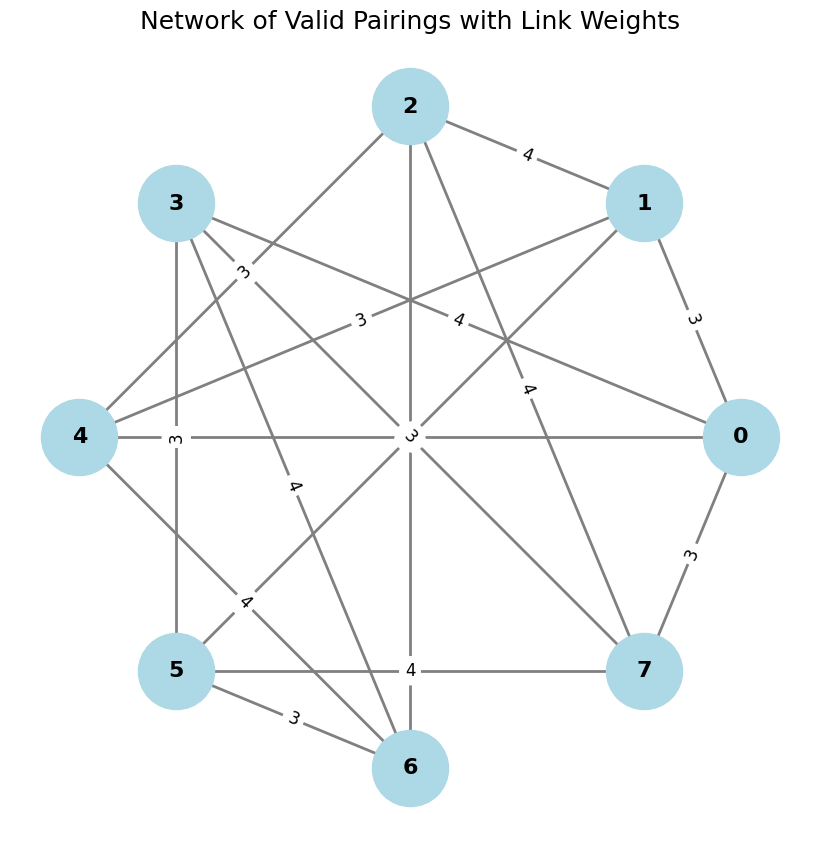

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

# Create a C₄-regular graph with 8 nodes (for example, using a known construction)
G = nx.generators.random_graphs.random_regular_graph(4, 8)

# Find all the edges
edges = list(G.edges())

# Count the number of valid pairings
valid_pairings = []
for comb in combinations(edges, 4):
    # Check if all nodes in the selected pairs are distinct
    nodes_in_pairs = [node for edge in comb for node in edge]
    if len(set(nodes_in_pairs)) == 8:  # All nodes are distinct
        valid_pairings.append(comb)

# Count the number of times each pair of nodes appear across all valid pairings
pair_counts = defaultdict(int)

for pairing in valid_pairings:
    for edge in pairing:
        # Ensure the pair is always sorted, to avoid double-counting (i.e., (0, 1) and (1, 0))
        pair_counts[tuple(sorted(edge))] += 1

# Create a graph and add edges with the frequency count as weights
network = nx.Graph()

# Add nodes from 0 to 7
network.add_nodes_from(range(8))

# Add weighted edges (pair count as weight)
for pair, count in pair_counts.items():
    network.add_edge(pair[0], pair[1], weight=count)

# Plot the network with a circular layout
node_order = list(range(8))

# Calculate positions for each node in a circle
angle = 2 * np.pi / len(node_order)
pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}

# Draw the network
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=16, font_weight='bold', edge_color='gray', width=2)

# Draw edge labels for weights
edge_labels = nx.get_edge_attributes(network, 'weight')
nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels, font_size=12)

plt.title("Network of Valid Pairings with Link Weights", fontsize=18)
plt.show()



In [4]:
#NEW CODE USE THIS
import numpy as np

def find_connected_pairs(adjacency_matrix):
    connected_pairs = []
    num_nodes = len(adjacency_matrix)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Ensure we only consider distinct pairs
            if adjacency_matrix[i][j] == 1:  # If there's a connection between nodes i and j
                connected_pairs.append([i, j])  # Use a list [i, j] instead of a tuple (i, j)

    return connected_pairs

def find_two_node_subgroups(adjacency_matrix, num_pairs):
    connected_pairs = find_connected_pairs(adjacency_matrix)
    num_nodes = len(adjacency_matrix)
    
    all_subgroups = []
    
    def is_valid(curr_pair):
        nodes = [node for pair in curr_pair for node in pair]
        return len(set(nodes)) == num_nodes
    
    def backtrack(curr_pair, remaining_pairs):
        if len(curr_pair) == num_pairs:
            sorted_curr_pair = sorted(curr_pair)
            if is_valid(sorted_curr_pair):
                all_subgroups.append(sorted_curr_pair)
            return
        
        for pair in remaining_pairs:
            if all(node not in [n for p in curr_pair for n in p] for node in pair):
                curr_pair.append(pair)
                next_pairs = [p for p in remaining_pairs if p != pair]
                backtrack(curr_pair, next_pairs)
                curr_pair.pop()
    
    backtrack([], connected_pairs)
    
    # Remove duplicates
    unique_subgroups = {frozenset(map(tuple, subgroup)) for subgroup in all_subgroups}
    unique_subgroups = [list(map(list, subgroup)) for subgroup in unique_subgroups]
    
    # Convert the result to a list of np.array
    unique_subgroups_np = [np.array(subgroup) for subgroup in unique_subgroups]
    
    return unique_subgroups_np

# Example usage:
adjacency_matrix = [
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
]
num_pairs = 2
subgroups = find_two_node_subgroups(adjacency_matrix, num_pairs)

print("Unique subgroups of pairs as np.array:")
print(subgroups)



Unique subgroups of pairs as np.array:
[array([[0, 1],
       [2, 3]]), array([[0, 2],
       [1, 3]])]


In [3]:
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adj_matrix = [[0,1,1,0,0,0,0,0,0,0,1,1],
                    [1,0,1,1,0,0,0,0,0,0,0,1],
                    [1,1,0,1,1,0,0,0,0,0,0,0],
                    [0,1,1,0,1,1,0,0,0,0,0,0],
                    [0,0,1,1,0,1,1,0,0,0,0,0],
                    [0,0,0,1,1,0,1,1,0,0,0,0],
                    [0,0,0,0,1,1,0,1,1,0,0,0],
                    [0,0,0,0,0,1,1,0,1,1,0,0],
                    [0,0,0,0,0,0,1,1,0,1,1,0],
                    [0,0,0,0,0,0,0,1,1,0,1,1],
                    [1,0,0,0,0,0,0,0,1,1,0,1],
                    [1,1,0,0,0,0,0,0,0,1,1,0]]

adj_matrix= [[0,1,1,0,1,1],[1,0,1,1,0,1],[1,1,0,1,1,0],[0,1,1,0,1,1],[1,0,1,1,0,1],[1,1,0,1,1,0]]

# Find all possible combinations of two-node connected subgroups
num_pairs = 3
two_node_subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("All possible combinations of two-node connected subgroups:")
all_groups=[]
for subgroup in two_node_subgroups:
    all_groups.append(subgroup)
    #print(subgroup)
all_groups

All possible combinations of two-node connected subgroups:


[[[1, 2], [0, 4], [3, 5]],
 [[4, 5], [0, 2], [1, 3]],
 [[0, 1], [2, 4], [3, 5]],
 [[1, 2], [3, 4], [0, 5]],
 [[2, 4], [1, 3], [0, 5]],
 [[2, 3], [0, 4], [1, 5]],
 [[0, 2], [3, 4], [1, 5]],
 [[0, 1], [4, 5], [2, 3]]]

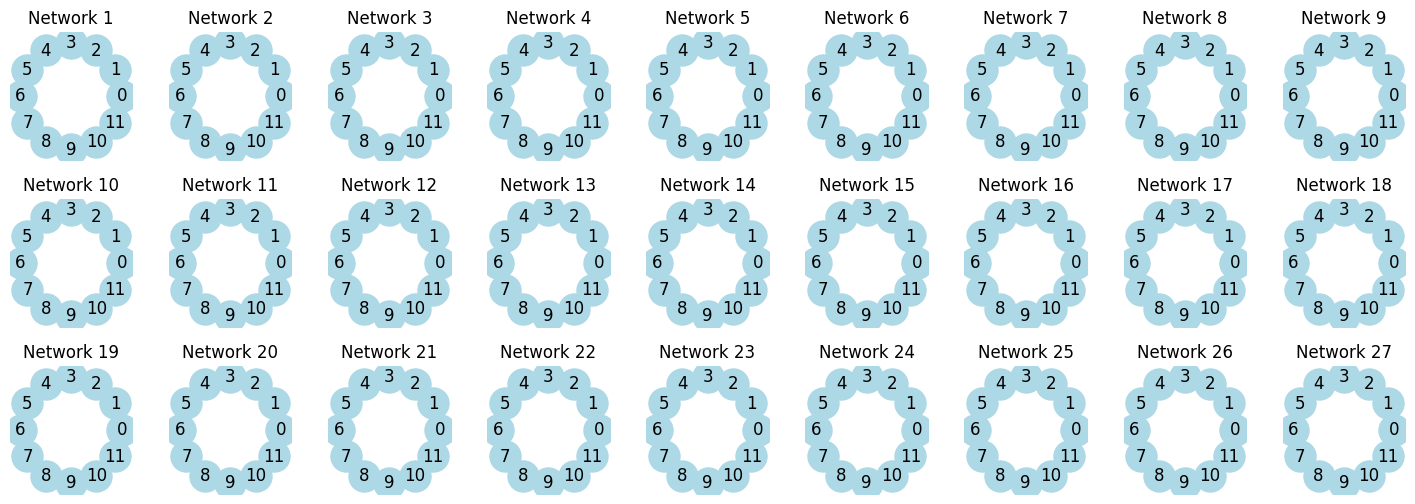

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Your input data
list_of_pairs = all_groups

# Ensure the list has exactly 14 entries for demonstration
#while len(list_of_pairs) < 12:
#    list_of_pairs.append(np.array([[0, 1], [2, 3], [4, 5], [6, 7]]))

# Set up the plot
fig, axes = plt.subplots(3, 9, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Helper function to visualize a graph from a list of pairs
def visualize_network(pairs, ax, title):
    G = nx.Graph()
    G.add_edges_from(pairs)
    node_order = list(range(12))

# Calculate positions for each node in a circle
    angle = 2 * np.pi / len(node_order)
    pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, edge_color='gray', ax=ax)
    ax.set_title(title, fontsize=12)

# Plot each network in the grid
for idx, ax in enumerate(axes.flat):
    if idx < len(list_of_pairs):
        visualize_network(list_of_pairs[idx], ax, f"Network {idx + 1}")
    else:
        ax.axis('off')  # Turn off empty plots

#plt.savefig("C4_all_2_q_subgroupings_8Q.png")

plt.show()

Pair (np.int64(10), np.int64(11)) appears 8 times
Pair (np.int64(6), np.int64(7)) appears 8 times
Pair (np.int64(4), np.int64(5)) appears 8 times
Pair (np.int64(0), np.int64(2)) appears 10 times
Pair (np.int64(8), np.int64(9)) appears 8 times
Pair (np.int64(1), np.int64(3)) appears 10 times
Pair (np.int64(9), np.int64(10)) appears 8 times
Pair (np.int64(1), np.int64(2)) appears 8 times
Pair (np.int64(3), np.int64(4)) appears 8 times
Pair (np.int64(0), np.int64(11)) appears 8 times
Pair (np.int64(5), np.int64(6)) appears 8 times
Pair (np.int64(7), np.int64(8)) appears 8 times
Pair (np.int64(8), np.int64(10)) appears 10 times
Pair (np.int64(7), np.int64(9)) appears 10 times
Pair (np.int64(9), np.int64(11)) appears 10 times
Pair (np.int64(2), np.int64(4)) appears 10 times
Pair (np.int64(6), np.int64(8)) appears 10 times
Pair (np.int64(5), np.int64(7)) appears 10 times
Pair (np.int64(0), np.int64(1)) appears 8 times
Pair (np.int64(3), np.int64(5)) appears 10 times
Pair (np.int64(4), np.int

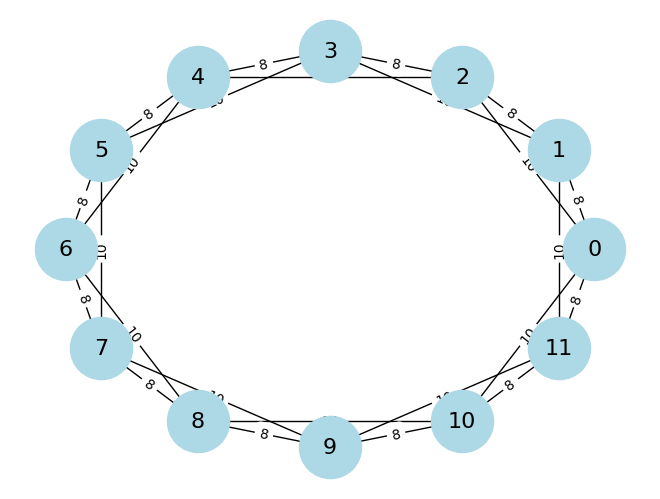

Edges with weights:
(np.int64(10), np.int64(11), {'weight': 8})
(np.int64(10), np.int64(9), {'weight': 8})
(np.int64(10), np.int64(8), {'weight': 10})
(np.int64(10), np.int64(0), {'weight': 10})
(np.int64(11), np.int64(0), {'weight': 8})
(np.int64(11), np.int64(9), {'weight': 10})
(np.int64(11), np.int64(1), {'weight': 10})
(np.int64(6), np.int64(7), {'weight': 8})
(np.int64(6), np.int64(5), {'weight': 8})
(np.int64(6), np.int64(8), {'weight': 10})
(np.int64(6), np.int64(4), {'weight': 10})
(np.int64(7), np.int64(8), {'weight': 8})
(np.int64(7), np.int64(9), {'weight': 10})
(np.int64(7), np.int64(5), {'weight': 10})
(np.int64(4), np.int64(5), {'weight': 8})
(np.int64(4), np.int64(3), {'weight': 8})
(np.int64(4), np.int64(2), {'weight': 10})
(np.int64(5), np.int64(3), {'weight': 10})
(np.int64(0), np.int64(2), {'weight': 10})
(np.int64(0), np.int64(1), {'weight': 8})
(np.int64(2), np.int64(1), {'weight': 8})
(np.int64(2), np.int64(3), {'weight': 8})
(np.int64(8), np.int64(9), {'weight':

In [12]:
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example list of lists, each containing 4 pairs of numbers
list_of_pairs = all_groups

# Flatten the list of lists and normalize pairs to always have smaller number first for consistency
pairs = [tuple(sorted(pair)) for sublist in list_of_pairs for pair in sublist]

# Count the occurrences of each pair
pair_counts = Counter(pairs)

# Print the counts
for pair, count in pair_counts.items():
    print(f"Pair {pair} appears {count} times")

# Create a graph
G = nx.Graph()

# Add edges to the graph with the count as the weight
for pair, count in pair_counts.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Get sorted list of nodes
nodes = sorted(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

# Create adjacency matrix
adj_matrix = np.zeros((len(nodes), len(nodes)))

for (u, v, data) in G.edges(data=True):
    adj_matrix[node_index[u], node_index[v]] = data["weight"]
    adj_matrix[node_index[v], node_index[u]] = data["weight"]  # Since it's an undirected graph

print("Adjacency Matrix:")
print(adj_matrix)

# Save adjacency matrix to file
#np.savetxt("adjacency_matrix.txt", adj_matrix, fmt="%d")

# Draw the graph
# Specify the desired node order (0, 1, 2, ..., 7)
node_order = list(range(12))

# Calculate positions for each node in a circle
angle = 2 * np.pi / len(node_order)
pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#plt.savefig("C4_all_2_q_subgroupings_8Q_frequency_of_pairings.png")
plt.show()

# Optionally print the edges and their weights
print("Edges with weights:")
for edge in G.edges(data=True):
    print(edge)



In [ ]:
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adjacency_matrix = [[0,1,0,0,0,0,0,0,0,0,0,1],
                    [1,0,1,0,0,0,0,0,0,0,0,0],
                    [0,1,0,1,0,0,0,0,0,0,0,0],
                    [0,0,1,0,1,0,0,0,0,0,0,0],
                    [0,0,0,1,0,1,0,0,0,0,0,0],
                    [0,0,0,0,1,0,1,0,0,0,0,0],
                    [0,0,0,0,0,1,0,1,0,0,0,0],
                    [0,0,0,0,0,0,1,0,1,0,0,0],
                    [0,0,0,0,0,0,0,1,0,1,0,0]
                    ,[0,0,0,0,0,0,0,0,1,0,1,0]
                    ,[0,0,0,0,0,0,0,0,0,1,0,1]
                    ,[1,0,0,0,0,0,0,0,0,0,1,0]]

# Find all possible combinations of two-node connected subgroups
num_pairs = 6
subgroups = find_two_node_subgroups(adjacency_matrix, num_pairs)
#print("Unique subgroups of pairs as np.array:")
print(subgroups)

In [7]:
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adjacency_matrix = [
    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]]

# Find all possible combinations of two-node connected subgroups
num_pairs = 7
subgroups = find_two_node_subgroups(adjacency_matrix, num_pairs)
#print("Unique subgroups of pairs as np.array:")
print(subgroups)

KeyboardInterrupt: 

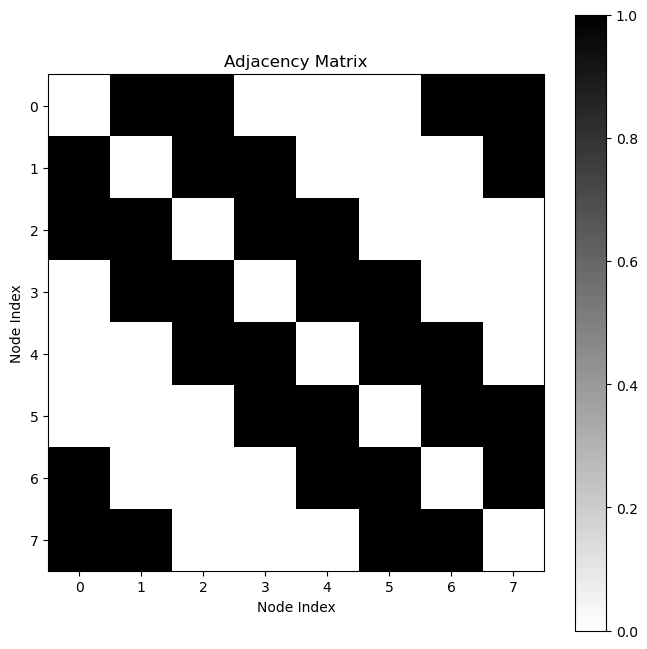

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the adjacency matrix
def plot_adjacency_matrix(adjacency_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.colorbar()
    plt.show()

plot_adjacency_matrix(adj_matrix)

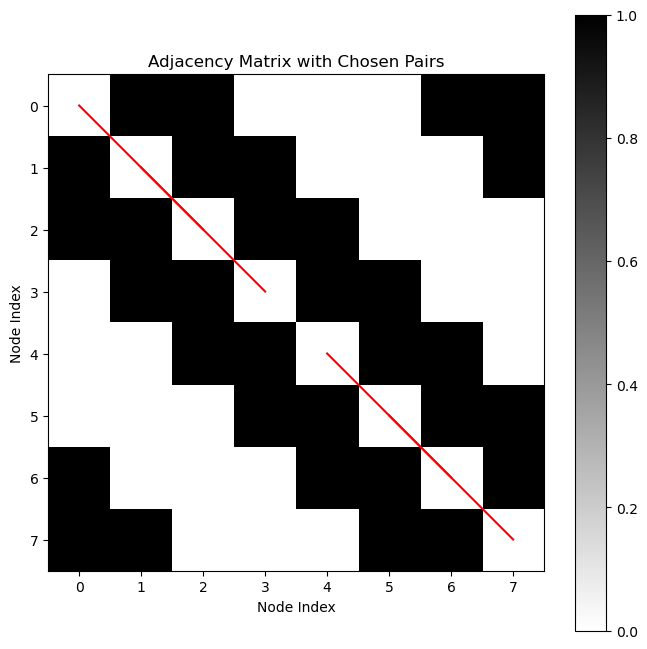

In [25]:
# Function to plot the chosen pairs of nodes
def plot_chosen_pairs(adjacency_matrix, chosen_pairs):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix with Chosen Pairs')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    
    # Plot chosen pairs
    for pair in chosen_pairs:
        plt.plot(pair, pair, color='red')  # Plot each pair
        
    plt.colorbar()
    plt.show()
chosen_pairs =[(0, 2), (4, 6), (1, 3), (5, 7)]
plot_chosen_pairs(adj_matrix, chosen_pairs)

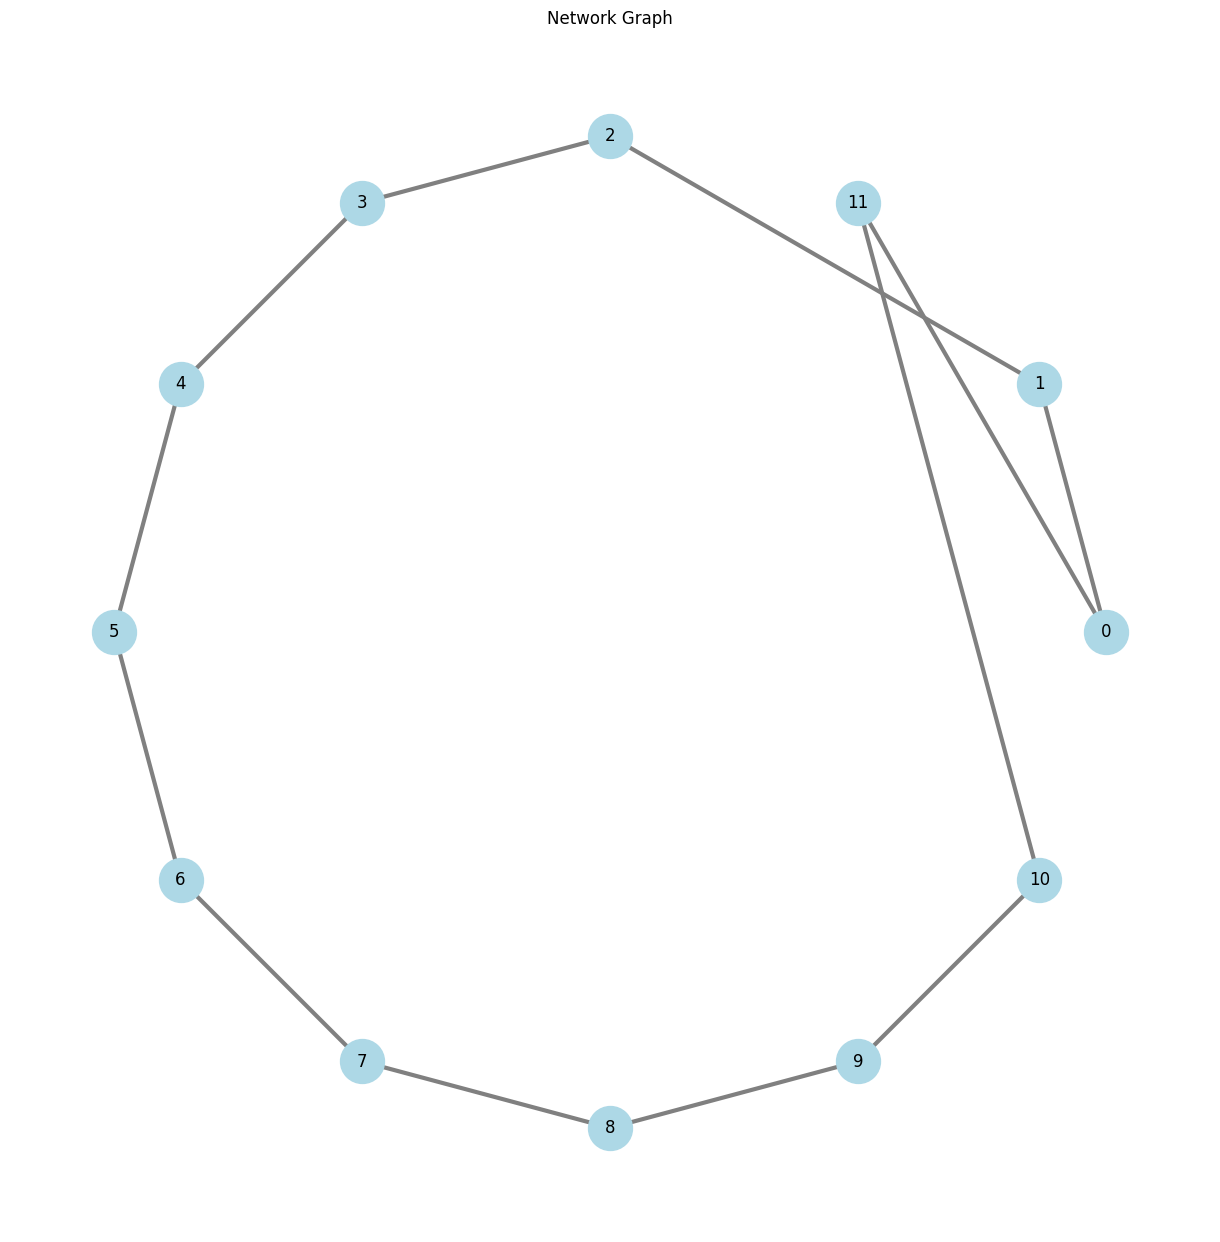

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

adjacency_matrix = [[0,1,0,0,0,0,0,0,0,0,0,1],
                    [1,0,1,0,0,0,0,0,0,0,0,0],
                    [0,1,0,1,0,0,0,0,0,0,0,0],
                    [0,0,1,0,1,0,0,0,0,0,0,0],
                    [0,0,0,1,0,1,0,0,0,0,0,0],
                    [0,0,0,0,1,0,1,0,0,0,0,0],
                    [0,0,0,0,0,1,0,1,0,0,0,0],
                    [0,0,0,0,0,0,1,0,1,0,0,0],
                    [0,0,0,0,0,0,0,1,0,1,0,0],
                    [0,0,0,0,0,0,0,0,1,0,1,0],
                    [0,0,0,0,0,0,0,0,0,1,0,1],
                    [1,0,0,0,0,0,0,0,0,0,1,0]]

def plot_network_graph(adjacency_matrix):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    
    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    
    pos = nx.circular_layout(G)  # Positions for all nodes
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='lightblue',edge_color="gray", node_size=1000,  width=3,font_size=12)
    plt.title('Network Graph')
    plt.show()


plot_network_graph(adjacency_matrix)

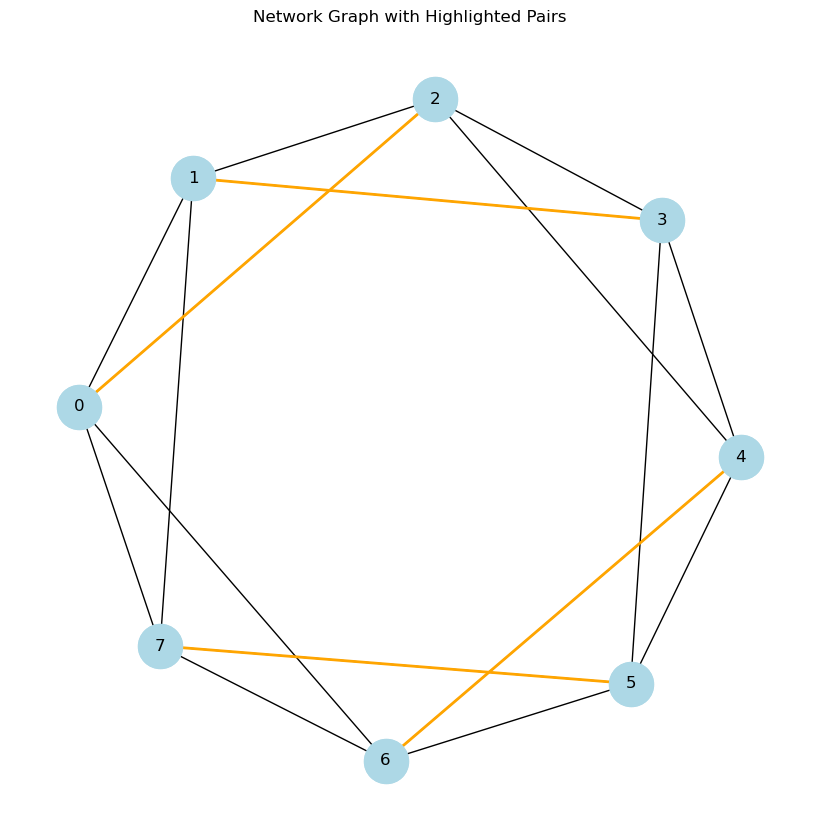

In [33]:
# Function to plot the network graph with highlighted pairs
def plot_network_graph_with_highlight(adjacency_matrix, chosen_pairs):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    
    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    
    pos = nx.spring_layout(G)  # Positions for all nodes
    
    plt.figure(figsize=(8, 8))
    
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12)
    
    # Highlight chosen pairs
    for pair in chosen_pairs:
        nx.draw_networkx_edges(G, pos, edgelist=[pair], width=2, edge_color='orange')
        nx.draw_networkx_nodes(G, pos, nodelist=pair, node_color='lightblue', node_size=1000)
    
    plt.title('Network Graph with Highlighted Pairs')
    plt.show()

# Plot the network graph with highlighted pairs
plot_network_graph_with_highlight(adj_matrix, chosen_pairs)

In [9]:
import itertools

def generate_pairs(objects):
    if len(objects) % 2 != 0:
        raise ValueError("Number of objects must be even to form pairs.")
    
    # Generate all possible pairs of objects
    pairs = list(itertools.combinations(objects, 2))
    
    # Function to check if a set of pairs is valid (no overlapping objects)
    def is_valid_combination(pair_comb):
        seen = set()
        for pair in pair_comb:
            if pair[0] in seen or pair[1] in seen:
                return False
            seen.update(pair)
        return True
    
    # Generate all unique combinations of pairs
    pair_combinations = list(itertools.combinations(pairs, len(objects) // 2))
    
    # Filter valid combinations
    valid_combinations = [comb for comb in pair_combinations if is_valid_combination(comb)]
    
    # Convert each combination to a numpy array of lists
    valid_combinations = [np.array([list(pair) for pair in comb]) for comb in valid_combinations]
    
    return valid_combinations

# Example usage
objects = list(range(12))
unique_pairs = generate_pairs(objects)

# Output the result
#print(f"Number of unique ways to form pairs: {len(unique_pairs)}")
len(unique_pairs)

10395

In [12]:
# Specify the file name
file_name = 'pairs.txt'

# Open the file in write mode
with open(file_name, 'w') as file:
    for i, array in enumerate(unique_pairs):
        # Write array to file
        np.savetxt(file, array, fmt='%d')
        # Add a separator between arrays
        file.write('\n---\n')

print(f"List of arrays saved to {file_name}")

List of arrays saved to pairs.txt


In [2]:
# Add directory above current directory to path
import sys as SYS; SYS.path.insert(0, '..')

# for saving
import os

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo

In [7]:
orders.n_random_cN_2local_orders(10,2)

array([[0, 1],
       [2, 4],
       [5, 8],
       [6, 7],
       [3, 9]])

In [17]:
unique_pairs[1000:2000]

[array([[ 0,  2],
        [ 1,  3],
        [ 4,  8],
        [ 5, 10],
        [ 6,  9],
        [ 7, 11]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  8],
        [ 5, 10],
        [ 6, 11],
        [ 7,  9]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  8],
        [ 5, 11],
        [ 6,  7],
        [ 9, 10]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  8],
        [ 5, 11],
        [ 6,  9],
        [ 7, 10]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  8],
        [ 5, 11],
        [ 6, 10],
        [ 7,  9]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  9],
        [ 5,  6],
        [ 7,  8],
        [10, 11]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  9],
        [ 5,  6],
        [ 7, 10],
        [ 8, 11]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  9],
        [ 5,  6],
        [ 7, 11],
        [ 8, 10]]),
 array([[ 0,  2],
        [ 1,  3],
        [ 4,  9],
        [ 5,  7],
        [ 6,  8],
        [10, 11]]),
 array([[ 

In [20]:
unique_pairs[2000:3000]

[array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6,  8],
        [ 7, 11],
        [ 9, 10]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6,  9],
        [ 7,  8],
        [10, 11]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6,  9],
        [ 7, 10],
        [ 8, 11]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6,  9],
        [ 7, 11],
        [ 8, 10]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6, 10],
        [ 7,  8],
        [ 9, 11]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6, 10],
        [ 7,  9],
        [ 8, 11]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6, 10],
        [ 7, 11],
        [ 8,  9]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6, 11],
        [ 7,  8],
        [ 9, 10]]),
 array([[ 0,  3],
        [ 1,  4],
        [ 2,  5],
        [ 6, 11],
        [ 7,  9],
        [ 8, 10]]),
 array([[ 

In [19]:
unique_pairs[3000:4000]

[array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  6],
        [ 7,  8],
        [10, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  6],
        [ 7, 10],
        [ 8, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  6],
        [ 7, 11],
        [ 8, 10]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  7],
        [ 6,  8],
        [10, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  7],
        [ 6, 10],
        [ 8, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  7],
        [ 6, 11],
        [ 8, 10]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  8],
        [ 6,  7],
        [10, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  8],
        [ 6, 10],
        [ 7, 11]]),
 array([[ 0,  4],
        [ 1,  3],
        [ 2,  9],
        [ 5,  8],
        [ 6, 11],
        [ 7, 10]]),
 array([[ 

In [21]:
unique_pairs[4000:5000]

[array([[ 0,  5],
        [ 1,  4],
        [ 2,  3],
        [ 6, 10],
        [ 7,  9],
        [ 8, 11]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  3],
        [ 6, 10],
        [ 7, 11],
        [ 8,  9]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  3],
        [ 6, 11],
        [ 7,  8],
        [ 9, 10]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  3],
        [ 6, 11],
        [ 7,  9],
        [ 8, 10]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  3],
        [ 6, 11],
        [ 7, 10],
        [ 8,  9]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  6],
        [ 3,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  6],
        [ 3,  7],
        [ 8, 10],
        [ 9, 11]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  6],
        [ 3,  7],
        [ 8, 11],
        [ 9, 10]]),
 array([[ 0,  5],
        [ 1,  4],
        [ 2,  6],
        [ 3,  8],
        [ 7,  9],
        [10, 11]]),
 array([[ 

In [22]:
unique_pairs[5000:6000]

[array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3,  7],
        [ 5, 11],
        [ 8, 10]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3,  8],
        [ 5,  7],
        [10, 11]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3,  8],
        [ 5, 10],
        [ 7, 11]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3,  8],
        [ 5, 11],
        [ 7, 10]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3, 10],
        [ 5,  7],
        [ 8, 11]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3, 10],
        [ 5,  8],
        [ 7, 11]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3, 10],
        [ 5, 11],
        [ 7,  8]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3, 11],
        [ 5,  7],
        [ 8, 10]]),
 array([[ 0,  6],
        [ 1,  4],
        [ 2,  9],
        [ 3, 11],
        [ 5,  8],
        [ 7, 10]]),
 array([[ 

In [24]:
unique_pairs[6000:7000]

[array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  6],
        [ 8,  9],
        [10, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  6],
        [ 8, 10],
        [ 9, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  6],
        [ 8, 11],
        [ 9, 10]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  8],
        [ 6,  9],
        [10, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  8],
        [ 6, 10],
        [ 9, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  8],
        [ 6, 11],
        [ 9, 10]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  9],
        [ 6,  8],
        [10, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  9],
        [ 6, 10],
        [ 8, 11]]),
 array([[ 0,  7],
        [ 1,  5],
        [ 2,  4],
        [ 3,  9],
        [ 6, 11],
        [ 8, 10]]),
 array([[ 

In [25]:
unique_pairs[7000:8000]

[array([[ 0,  8],
        [ 1,  5],
        [ 2,  9],
        [ 3, 10],
        [ 4,  7],
        [ 6, 11]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2,  9],
        [ 3, 10],
        [ 4, 11],
        [ 6,  7]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2,  9],
        [ 3, 11],
        [ 4,  6],
        [ 7, 10]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2,  9],
        [ 3, 11],
        [ 4,  7],
        [ 6, 10]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2,  9],
        [ 3, 11],
        [ 4, 10],
        [ 6,  7]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2, 10],
        [ 3,  4],
        [ 6,  7],
        [ 9, 11]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2, 10],
        [ 3,  4],
        [ 6,  9],
        [ 7, 11]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2, 10],
        [ 3,  4],
        [ 6, 11],
        [ 7,  9]]),
 array([[ 0,  8],
        [ 1,  5],
        [ 2, 10],
        [ 3,  6],
        [ 4,  7],
        [ 9, 11]]),
 array([[ 

In [26]:
unique_pairs[8000:9000]

[array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3,  7],
        [ 5, 11],
        [ 8, 10]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3,  8],
        [ 5,  7],
        [10, 11]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3,  8],
        [ 5, 10],
        [ 7, 11]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3,  8],
        [ 5, 11],
        [ 7, 10]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3, 10],
        [ 5,  7],
        [ 8, 11]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3, 10],
        [ 5,  8],
        [ 7, 11]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3, 10],
        [ 5, 11],
        [ 7,  8]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3, 11],
        [ 5,  7],
        [ 8, 10]]),
 array([[ 0,  9],
        [ 1,  6],
        [ 2,  4],
        [ 3, 11],
        [ 5,  8],
        [ 7, 10]]),
 array([[ 